# Technical: Training models across animals

* This notebook will demo how to use a multisession CEBRA implementation.
* We will compare embeddings obtained on 4 rat datasets when trained on four single-session models vs. one multisession model.
* We will use CEBRA-Behavior (``conditional='time_delta'``) for both single and multi session implementation.
* Each individual single session output embedding is aligned to the first session.


**How multi-session training works:**

* For flexibility, it is implemented so that it does not fit one model for all sessions. Consequently, it is possible to use sessions that do not have the same number of data features (e.g., not the same number of neurons from one session to the other). The number of samples can also vary (true for single session too).
* It fits one model per session but the pos/neg sampling is performed across all sessions, making the models invariant to the labels across all sessions.


**When to use multi-session training:**

Check out the following list to verify if our multisession implementation is the right tool for your needs.

* I have multiple sessions or animals that I want to consider as a *pseudo-subject* and use them jointly for training CEBRA. 
* That is the case because of limited access to simultaneously recorded neurons or looking for animal-invariant features in the neural data. 
* I want to get more consistent embeddings from one session or animal to the other. 
* I want to be able to use CEBRA for a new session that is fully *unseen* during training (e.g., could be useful for a brain machine interface applications).
* **WARNING:** I am not interested in the influence of individual variations of the label features from one session/animal to the other on the resulting embedding. I do not need those session or animal specific information.


**Install note** 

Be sure you have cebra, and the demo dependencies, installed to use this notebook: 

In [1]:
!pip install 'cebra[datasets,demos]'

In [2]:
import sys

import matplotlib.pyplot as plt
import cebra.data
import cebra.datasets
import cebra.integrations
from cebra import CEBRA
import matplotlib.pyplot as plt
import pickle

/home/rodrigo/miniconda/miniconda/envs/cebra/lib/python3.8/site-packages/cebra/datasets/monkey_reaching.py:35: UserWarning: Could not import the nlb_tools package required for data loading of cebra.datasets.monkey_reaching. Dataset will not be available. If required, you can install the dataset by running pip install git+https://github.com/neurallatents/nlb_tools.
  warnings.warn(


- Be sure you have downloaded the data and placed `/data` from [FigShare](https://figshare.com/s/60adb075234c2cc51fa3) and into the `demo_notebooks` directory. Let's check if it's there:

In [3]:
ls

data/                                Demo_hypothesis_testing.ipynb
Demo_Allen.ipynb                     Demo_learnable_temperature.ipynb
Demo_cohomology.ipynb                Demo_primate_reaching.ipynb
Demo_consistency.ipynb               Demo_primate_reaching_mse_loss.ipynb
Demo_conv-pivae.ipynb                Demo_synthetic_exp.ipynb
Demo_decoding.ipynb                  LICENSE
Demo_hippocampus.ipynb               rat_demo_example_output.h5
Demo_hippocampus_multisession.ipynb  README.rst


## Load the data

In [4]:
hippocampus_a = cebra.datasets.init('rat-hippocampus-single-achilles')
hippocampus_b = cebra.datasets.init('rat-hippocampus-single-buddy')
hippocampus_c = cebra.datasets.init('rat-hippocampus-single-cicero')
hippocampus_g = cebra.datasets.init('rat-hippocampus-single-gatsby')

In [5]:
names = ["achilles", "buddy", "cicero", "gatsby"]
datas = [hippocampus_a.neural.numpy(), hippocampus_b.neural.numpy(), hippocampus_c.neural.numpy(), hippocampus_g.neural.numpy()]
labels = [hippocampus_a.continuous_index.numpy(), hippocampus_b.continuous_index.numpy(), hippocampus_c.continuous_index.numpy(), hippocampus_g.continuous_index.numpy()]

## Single-session training

Create and fit one single session model per dataset

In [6]:
max_iterations = 100 # by default, 5000 iterations

In [7]:
embeddings = dict()

# Single session training
for name, X, y in zip(names, datas, labels):
    # Fit one CEBRA model per session (i.e., per rat)
    print(f"Fitting CEBRA for {name}")
    cebra_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

    cebra_model.fit(X, y)
    embeddings[name] = cebra_model.transform(X)


# Align the single session embeddings to the first rat
alignment = cebra.data.helper.OrthogonalProcrustesAlignment()
first_rat = list(embeddings.keys())[0]

for j, rat_name in enumerate(list(embeddings.keys())[1:]):
    embeddings[f"{rat_name}"] = alignment.fit_transform(
        embeddings[first_rat], embeddings[rat_name], labels[0], labels[j+1])


# Save embeddings in current folder
with open('embeddings.pkl', 'wb') as f:
    pickle.dump(embeddings, f)


Fitting CEBRA for achilles


pos:  0.2263 neg:  5.4477 total:  5.6740 temperature:  1.0000: 100%|██████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.05it/s]


Fitting CEBRA for buddy


pos:  0.4821 neg:  5.5237 total:  6.0058 temperature:  1.0000: 100%|██████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 58.80it/s]


Fitting CEBRA for cicero


pos:  0.4156 neg:  5.7495 total:  6.1650 temperature:  1.0000: 100%|██████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 78.19it/s]


Fitting CEBRA for gatsby


pos:  0.4044 neg:  5.6249 total:  6.0293 temperature:  1.0000: 100%|██████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 74.23it/s]


## Multisession training

Create and fit one multi-session model on all datasets

In [8]:
multi_embeddings = dict()

# Multisession training
multi_cebra_model = CEBRA(model_architecture='offset10-model',
                    batch_size=512,
                    learning_rate=3e-4,
                    temperature=1,
                    output_dimension=3,
                    max_iterations=max_iterations,
                    distance='cosine',
                    conditional='time_delta',
                    device='cuda_if_available',
                    verbose=True,
                    time_offsets=10)

# Provide a list of data, i.e. datas = [data_a, data_b, ...]
multi_cebra_model.fit(datas, labels)

# Transform each session with the right model, by providing the corresponding session ID
for i, (name, X) in enumerate(zip(names, datas)):
    multi_embeddings[name] = multi_cebra_model.transform(X, session_id=i)

# Save embeddings in current folder
with open('multi_embeddings.pkl', 'wb') as f:
    pickle.dump(multi_embeddings, f)

pos:  0.4349 neg:  6.9797 total:  7.4146 temperature:  1.0000: 100%|██████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.60it/s]


## Compare embeddings

Also see [Extended Data Figure 7](https://cebra.ai/docs/cebra-figures/figures/ExtendedDataFigure7.html) of Schneider, Lee, Mathis.

In [9]:
with open('embeddings.pkl', 'rb') as f:
    embeddings = pickle.load(f)
with open('multi_embeddings.pkl', 'rb') as f:
    multi_embeddings = pickle.load(f)

In [12]:
def plot_hippocampus(ax, embedding, label, gray = False, idx_order = (0,1,2)):
    r_ind = label[:,1] == 1
    l_ind = label[:,2] == 1
    
    if not gray:
        r_cmap = 'cool'
        l_cmap = 'viridis'
        r_c = label[r_ind, 0]
        l_c = label[l_ind, 0]
    else:
        r_cmap = None
        l_cmap = None
        r_c = 'gray'
        l_c = 'gray'
    
    idx1, idx2, idx3 = idx_order
    r=ax.scatter(embedding [r_ind,idx1], 
               embedding [r_ind,idx2], 
               embedding [r_ind,idx3], 
               c=r_c,
               cmap=r_cmap, s=0.05, alpha=0.75)
    l=ax.scatter(embedding [l_ind,idx1], 
               embedding [l_ind,idx2], 
               embedding [l_ind,idx3], 
               c=l_c,
               cmap=l_cmap, s=0.05, alpha=0.75)
    
    ax.grid(False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
        
    return ax

**Note to Google Colaboratory users:** replace the first line of the next cell (``%matplotlib notebook``) with ``%matplotlib inline``.

%matplotlib inline

fig = plt.figure(figsize=(10,6))

ax1 = plt.subplot(241, projection='3d')
ax2 = plt.subplot(242, projection='3d')
ax3 = plt.subplot(243, projection='3d')
ax4 = plt.subplot(244, projection='3d')
axs = [ax1, ax2, ax3, ax4]

ax5 = plt.subplot(245, projection='3d')
ax6 = plt.subplot(246, projection='3d')
ax7 = plt.subplot(247, projection='3d')
ax8 = plt.subplot(248, projection='3d')
axs_multi = [ax5, ax6, ax7, ax8]

for name, label, ax, ax_multi in zip(names, labels, axs, axs_multi):
    ax = plot_hippocampus(ax, embeddings[name], label)
    ax.set_title(f'Single-{name}', y=1, pad=-20)
    ax.axis('off')
    ax_multi = plot_hippocampus(ax_multi, multi_embeddings[name], label)
    ax_multi.set_title(f'Multi-{name}', y=1, pad=-20)
    ax_multi.axis('off')
    
    
plt.subplots_adjust(wspace=0,
                    hspace=0)
plt.show()

In [16]:
≈

{'achilles': array([[ 0.24287799,  0.17034858,  0.9549825 ],
        [-0.15072678,  0.19596799,  0.9689572 ],
        [-0.18626714,  0.30352882,  0.9344382 ],
        ...,
        [ 0.34342515,  0.5492445 ,  0.76183313],
        [ 0.16788875,  0.32663715,  0.9301191 ],
        [ 0.42049885,  0.26028374,  0.86915654]], dtype=float32),
 'buddy': array([[-0.3596853 ,  0.21568644, -0.90780294],
        [-0.38947132,  0.35536057, -0.8497241 ],
        [-0.21383509,  0.39446196, -0.89368594],
        ...,
        [-0.91645396, -0.36027244, -0.17411572],
        [-0.1692151 , -0.71148336, -0.6820252 ],
        [ 0.01878067, -0.6293062 , -0.776931  ]], dtype=float32),
 'cicero': array([[-0.6158745 , -0.7788903 ,  0.11844026],
        [-0.4232825 , -0.9059292 ,  0.01112168],
        [-0.34702244, -0.9363383 , -0.05334318],
        ...,
        [-0.58696455, -0.7584261 ,  0.2833057 ],
        [-0.6436958 , -0.71490484, -0.27306855],
        [-0.7569303 , -0.6136877 , -0.22459641]], dtype=float32

## Compute the consistency maps

Correlation matrices depict the $R^2$ after fitting a linear model between behavior-aligned embeddings of two animals, one as the target one as the source (mean, n=10 runs). Parameters were picked by optimizing average run consistency across rats.

In [23]:
# labels to align the subjects is the position of the mouse in the arena
labels = [data.continuous_index[:, 0]
          for data in [hippocampus_a, hippocampus_b, hippocampus_c, hippocampus_g]]




# CEBRA (single animal)
scores, pairs, subjects = cebra.sklearn.metrics.consistency_score(embeddings=list(embeddings.values()),
                                                                                 labels=labels,
                                                                                 dataset_ids=names,
                                                                                 between="datasets")

# CEBRA (multiple animals)
multi_scores, multi_pairs, multi_subjects = cebra.sklearn.metrics.consistency_score(embeddings=list(multi_embeddings.values()),
                                                                                 labels=labels,
                                                                                 dataset_ids=names,
                                                                                 between="datasets")


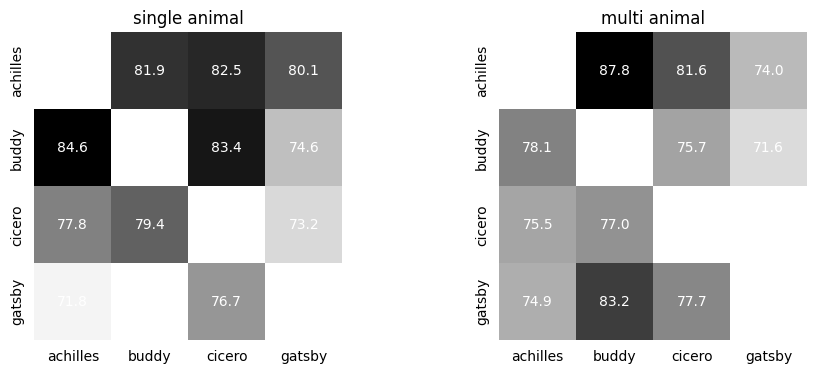

In [25]:
%matplotlib inline

# Display consistency maps
fig = plt.figure(figsize=(11, 4))

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax1 = cebra.plot_consistency(scores, pairs=pairs, datasets=subjects,
                             ax=ax1, title="single animal", colorbar_label=None)

ax2 = cebra.plot_consistency(multi_scores, pairs=multi_pairs, datasets=multi_subjects,
                             ax=ax2, title="multi animal", colorbar_label=None)
